In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current



In [2]:
output_folder = 'output_control'

conns = pd.read_csv('./{}/Connections.csv'.format(output_folder))


In [3]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))
conns.loc[conns.Type=='apic','Sec ID'] = conns.loc[conns.Type=='apic','Name'].apply(lambda x: int(x.split('apic[')[1].split(']')[0]))
conns.loc[conns.Type=='soma','Sec ID'] = conns.loc[conns.Type=='soma','Name'].apply(lambda x: int(x.split('soma[')[1].split(']')[0]))
conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))

conns['X'] = conns['Name'].apply(lambda x: float(x.split('(')[1].split(')')[0]))

conns.rename(columns={'Distance':'conns_Distance'},inplace=True)

conns['Sec ID'] = conns['Sec ID'].astype(int)
conns['X'] = conns['X'].astype(float)

In [4]:
conns.head()

,Node ID,conns_Distance,Conductance,Type,Name,Source Population,Release Probability,Sec ID,X
0,0,61.505696,0.500607,dend,L5PCtemplate[0].dend[60](0.264706),exc_stim,0.6,60,0.264706
1,0,112.522057,0.325079,dend,L5PCtemplate[0].dend[28](0.128571),exc_stim,0.6,28,0.128571
2,0,73.494480,0.554728,dend,L5PCtemplate[0].dend[29](0.7),exc_stim,0.6,29,0.700000
3,0,101.530468,1.005930,dend,L5PCtemplate[0].dend[33](0.264706),exc_stim,0.6,33,0.264706
4,0,65.675576,0.304560,dend,L5PCtemplate[0].dend[48](0.409091),exc_stim,0.6,48,0.409091


In [5]:
segs = pd.read_csv('L5Segments.csv')
segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs['segmentID'] = segs.index
segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False)
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False)

In [12]:
exc_syns_per_seg = conns[conns['Source Population']=='exc_stim'].groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})




In [31]:
exc_syns_per_seg.head()

,Type,Sec ID,X,num_syns
0,apic,0,0.055556,10
1,apic,0,0.166667,5
2,apic,0,0.277778,17
3,apic,0,0.388889,4
4,apic,0,0.500000,3


In [44]:
segs['segmentID'] = segs.groupby(['Type','Sec ID']).cumcount()+1

In [45]:
exc_syns_per_seg['segmentID'] = exc_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1

In [50]:
exc_syns = segs.set_index(['Type','Sec ID','segmentID']).join(exc_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()


In [16]:
v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')

nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')

na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')
spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')

In [17]:
spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [8]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    threshold_crossings = np.diff(na['report']['biophysical']['data'][:,p] > 0.003, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
    if len(na_spks)>0:
        na_df = na_df.append(pd.DataFrame({'segmentID':np.tile(p,len(na_spks)),
                                               'na_lower_bound':na_spks}))
    else:
        na_df = na_df.append(pd.DataFrame({'segmentID':p,
                                               'na_lower_bound':np.array([np.nan])}))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


2513
2514
2515
2516
2517
2518
2519
2520


In [57]:
#na_df.to_csv('64Hz_soma_inh_na_df.csv')
na_df = pd.read_csv('na_df.csv')

In [121]:
for i in np.random.choice(na_df[(na_df.na_lower_bound>20) & (na_df.na_lower_bound<1400000)].index,10000):
    seg = na_df.loc[i,'segmentID']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan

In [126]:
na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [58]:
segs_na_df = segs.set_index('segmentID').join(na_df.set_index('segmentID')).reset_index()

In [59]:
def get_sta(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance>edges_dend[e])&
                                     (segs_na_df.Elec_distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance>edges_apic[e])&
                                     (segs_na_df.Elec_distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    return na_dend, na_apic

In [60]:
na_dend, na_apic = get_sta(segs_na_df, spktimes)

In [61]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [62]:
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

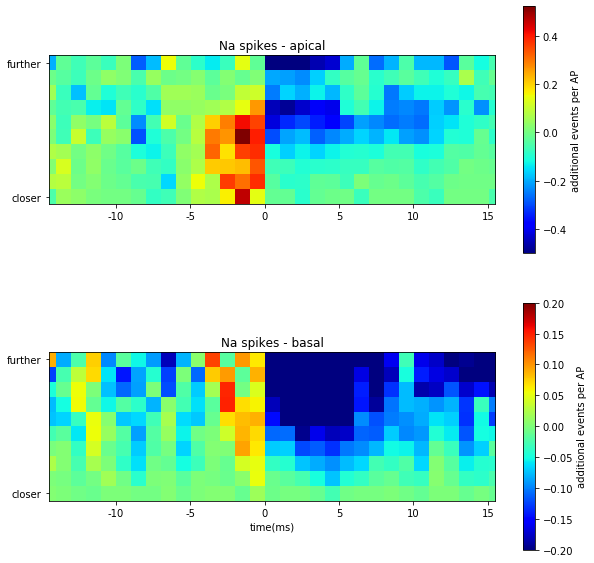

In [65]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow((na_apic-na_apic_rand)/len(spktimes),cmap='jet',vmin=-0.5)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.2, vmax=0.2)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)

plt.show()

----------

In [53]:
ca_df = pd.DataFrame(columns=['segmentID','ca_lower_bound'])

segIDs = segs[(segs.Type=='apic')]['segmentID']
for p in segIDs:
    print(p)
    trace = hva['report']['biophysical']['data'][:,p]+\
                lva['report']['biophysical']['data'][:,p]+\
                ih['report']['biophysical']['data'][:,p]
    m = np.mean(trace)
    s = np.std(trace)

    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=200)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=200)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
    
    if (len(legit_uc_iso)!=0) & (np.min(trace)!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=hva['report']['biophysical']['data'])
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'ca_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'ca_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'ca_lower_bound':np.nan,
                                               'ca_upper_bound':np.nan,
                                               'mag':np.nan}))

1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226


In [55]:
ca_df.to_csv('ca_df.csv')
#ca_df = pd.read_csv('ca_df.csv')

# durations

In [217]:
segs[(segs['Coord Y']>600)&(segs['Coord Y']<800)]

,Type,Sec ID,BMTK ID,X,Distance,Coord X,Coord Y,Coord Z,Elec_distance,segmentID,Degrees,Elec_distanceQ
459,apic,37,122,0.118182,671.034720,-34.973857,603.914939,1.574586,0.121849,1486,11,7
460,apic,37,122,0.136364,676.059718,-35.172710,608.816781,2.648283,0.118182,1487,11,7
461,apic,37,122,0.154545,681.084716,-35.172710,613.744600,3.629033,0.114700,1488,11,7
462,apic,37,122,0.172727,686.109714,-34.968832,618.393979,5.477332,0.111392,1489,11,7
463,apic,37,122,0.190909,691.134711,-35.410425,623.307217,5.993446,0.108246,1490,11,7
...,...,...,...,...,...,...,...,...,...,...,...,...
815,apic,60,145,0.627660,846.627753,-47.270383,778.441926,-7.096120,0.025375,1842,12,4
816,apic,60,145,0.648936,851.588041,-48.492018,783.156060,-7.837240,0.024687,1843,12,4
817,apic,60,145,0.670213,856.548330,-49.419451,787.982406,-8.215281,0.024031,1844,12,4
818,apic,60,145,0.691489,861.508619,-49.467465,792.908083,-8.094590,0.023407,1845,12,4


In [348]:
np.random.choice(segs[(segs['Coord Y']<-50)&
     (segs['Coord Y']>-100)&
     (segs['Coord X']>-50)&
     (segs['Coord X']<50)&
     (segs['Type']=='dend')]['segmentID'])

281

## Plotting morphology as heat maps

In [19]:
exc_syns.shape

(2526, 13)

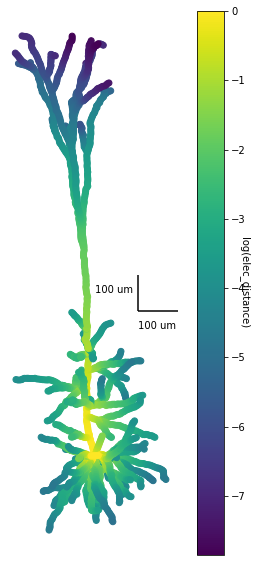

In [22]:
plt.figure(figsize=(4,10))
ax = plt.scatter(exc_syns['Coord X'], exc_syns['Coord Y'],c=np.log(exc_syns['Elec_distance']))
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.svg')

In [59]:
exc_syns.loc[pd.isnull(exc_syns.num_syns),'num_syns'] = 0

In [30]:
exc_syns[exc_syns.num_syns==0].shape, exc_syns[exc_syns.num_syns!=0].shape

((2310, 13), (216, 13))

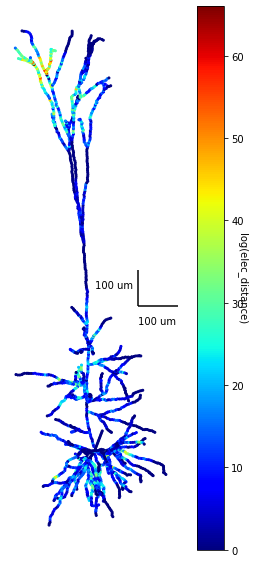

In [61]:
plt.figure(figsize=(4,10))
ax = plt.scatter(exc_syns['Coord X'], exc_syns['Coord Y'],c=exc_syns['num_syns'],s=4,cmap='jet')
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

## Plotting morphology and voltage traces

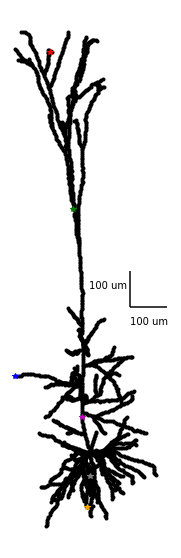

In [352]:
plt.figure(figsize=(3,10))
ax = plt.plot(segs['Coord X'], segs['Coord Y'],'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(segs.loc[segs.segmentID==1959,'Coord X'], 
         segs.loc[segs.segmentID==1959,'Coord Y'],
         'r*')
plt.plot(segs.loc[segs.segmentID==1112,'Coord X'], 
         segs.loc[segs.segmentID==1112,'Coord Y'],
         'b*')
plt.plot(segs.loc[segs.segmentID==1046,'Coord X'], 
         segs.loc[segs.segmentID==1046,'Coord Y'],
         'm*')
plt.plot(segs.loc[segs.segmentID==1500,'Coord X'], 
         segs.loc[segs.segmentID==1500,'Coord Y'],
         'g*')
plt.plot(segs.loc[segs.segmentID==680,'Coord X'], 
         segs.loc[segs.segmentID==680,'Coord Y'],
         '*',color='orange')
plt.plot(segs.loc[segs.segmentID==482,'Coord X'], 
         segs.loc[segs.segmentID==482,'Coord Y'],
         '*',color='grey')
plt.savefig('fig1A.svg')

In [58]:
v = h5py.File('../../../L5NeuronSimulation_expts/L5_control/L5_control_exc_med/L5NeuronSimulation/FullSimulation/output/v_report.h5','r')


In [351]:
t

482

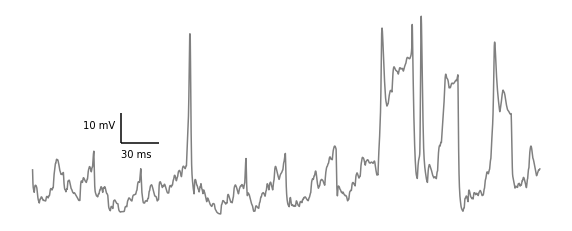

In [350]:
t = np.random.choice(segs[(segs['Coord Y']<-50)&
     (segs['Coord Y']>-100)&
     (segs['Coord X']>-50)&
     (segs['Coord X']<50)&
     (segs['Type']=='dend')]['segmentID'])

plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='grey')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2G.svg')

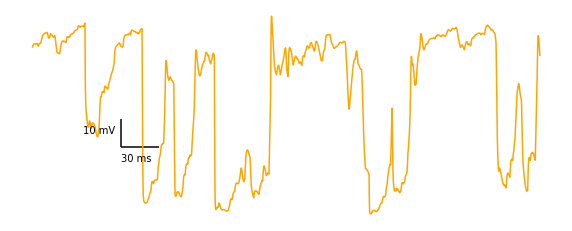

In [339]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,680],color='orange')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2F.svg')

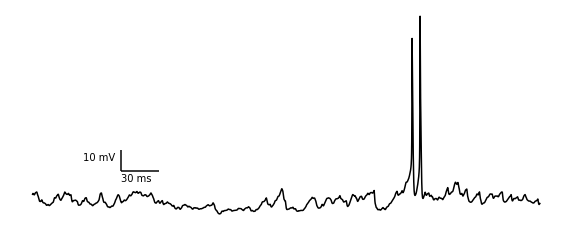

In [340]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2E.svg')

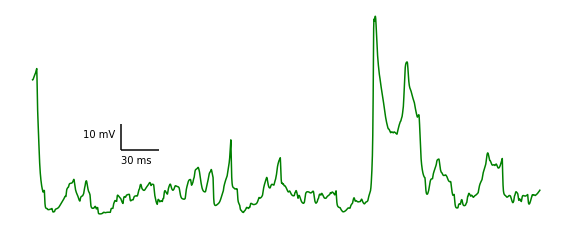

In [329]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,1500],color='g')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2C.svg')

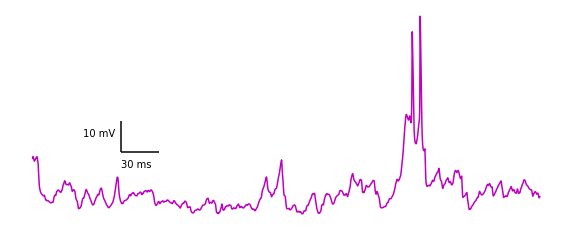

In [330]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,1046],color='m')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2D.svg')

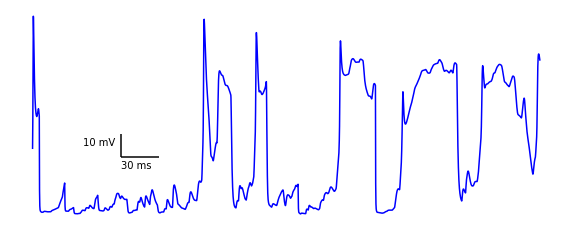

In [305]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,1112],color='b')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2B.svg')

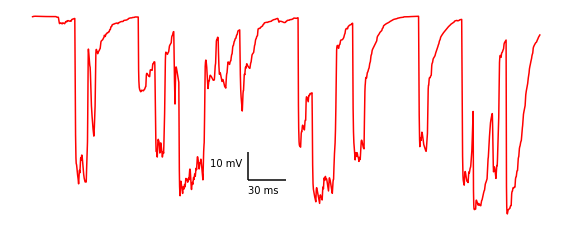

In [301]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,1959],color='r')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.text(170,-65,'30 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2A.svg')

In [267]:
s1

323548

([], <a list of 0 Text yticklabel objects>)

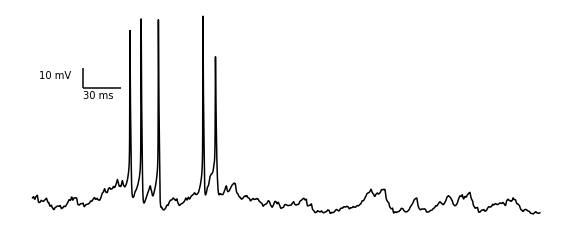

In [176]:
plt.figure(figsize=(10,4))
s1 = 559133+1000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
#1433413, 1161455
plt.hlines(-10,40,70)
plt.text(40,-15,'30 ms')
plt.vlines(40,-10,0)
plt.text(5,-5,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [195]:
x = ca_df[~pd.isnull(ca_df.ca_lower_bound)].reset_index()
i = np.random.choice(x.index)

(0, 200)

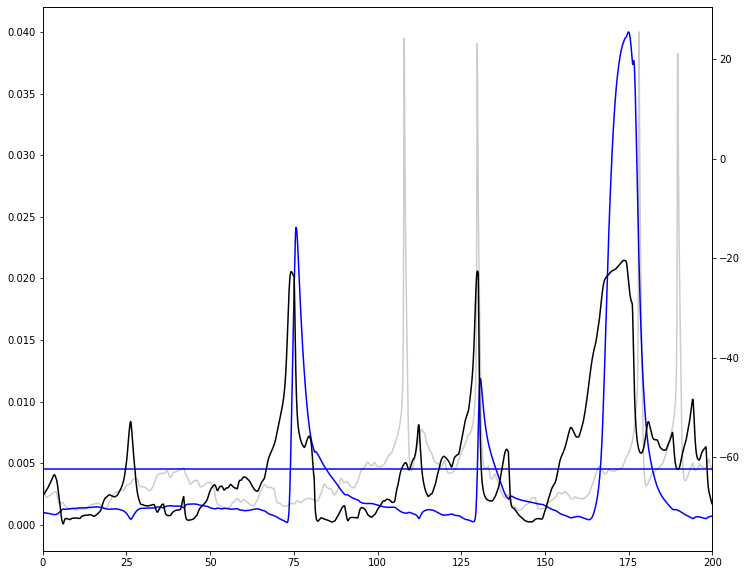

In [35]:
seg = 1842
lower_bound = 15000
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,600,.1),-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]),color='b')
plt.hlines(np.mean(-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg])),0,600,color='b')
plt.xlim(0,200)

plt.twinx()
plt.plot(np.arange(0,600,.1),v['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg],color='k')
plt.plot(np.arange(0,600,.1),v['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,0],color='k',alpha=0.2)
plt.xlim(0,200)


In [189]:
ca_df.reset_index(inplace=True)

In [201]:
for i in np.random.choice(ca_df[(ca_df.ca_lower_bound>2000) & (ca_df.ca_lower_bound<1400000)].index,100):
    seg = ca_df.loc[i,'segmentID']
    if not pd.isnull(ca_df.loc[i,'ca_lower_bound']):
        spkt = int(ca_df.loc[i,'ca_lower_bound'])
        
        trace = -(hva['report']['biophysical']['data'][spkt-1000:spkt+1000,seg] + \
                lva['report']['biophysical']['data'][spkt-1000:spkt+1000,seg] + \
                ih['report']['biophysical']['data'][spkt-1000:spkt+1000,seg])
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,2000)[trace>half_peak] + spkt - 10
        ca_df.loc[i,'duration_low'] = duration[0]
        ca_df.loc[i,'duration_high'] = duration[-1]
        ca_df.loc[i,'peak_value'] = peak_value
    else:
        ca_df.loc[i,'duration_low'] = np.nan
        ca_df.loc[i,'duration_high'] = np.nan
        ca_df.loc[i,'peak_value'] = np.nan

In [203]:
ca_df[~pd.isnull(ca_df.duration_high)]

,index,segmentID,ca_lower_bound,duration_low,duration_high,peak_value
2563,158,1069,507212,508191.0,508356.0,0.003170
4296,362,1072,1254601,1254678.0,1255713.0,0.002945
7196,105,1113,349293,350266.0,351131.0,0.002592
7241,150,1113,495356,495775.0,496369.0,0.003116
8421,400,1115,1259735,1260697.0,1261017.0,0.002950
...,...,...,...,...,...,...
311425,78,2403,204744,205494.0,205794.0,0.003171
312627,192,2405,457039,457064.0,458052.0,0.002928
314071,372,2407,810363,810543.0,812048.0,0.003003
315127,21,2409,55870,56852.0,57859.0,0.003151


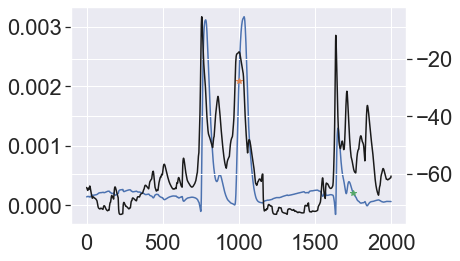

In [210]:
seg = 2403
lower_bound = 204744
#upper_bound = 
plt.plot(-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]))
plt.plot(1000,-(hva['report']['biophysical']['data'][lower_bound,seg]+\
         lva['report']['biophysical']['data'][lower_bound,seg]+\
         ih['report']['biophysical']['data'][lower_bound,seg]),'*')

plt.plot(1000+205494-lower_bound,-(hva['report']['biophysical']['data'][205494,seg]+\
         lva['report']['biophysical']['data'][205494,seg]+\
         ih['report']['biophysical']['data'][205494,seg]),'*')

plt.twinx()
plt.plot(v['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg],color='k')

----------

In [43]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID')).reset_index() 

In [44]:
def get_ca_sta(segs_ca_df, spktimes):

    ca_apic = np.zeros((10,39,))
    
    edges_apic=np.quantile(segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                       (segs_ca_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                ca_inds = segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                     (segs_ca_df.Type=='apic')&
                                     (segs_ca_df.Elec_distance>edges_apic[e])&
                                     (segs_ca_df.Elec_distance<=edges_apic[e+1])]['ca_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(ca_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                ca_apic[e] += x2
                
                
            
            actual_spktimes.append(i)
        c = i
    return ca_apic

In [45]:
ca_apic = get_ca_sta(segs_ca_df, spktimes)

In [46]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
ca_apic_rand = get_ca_sta(segs_ca_df, rand_spktimes)

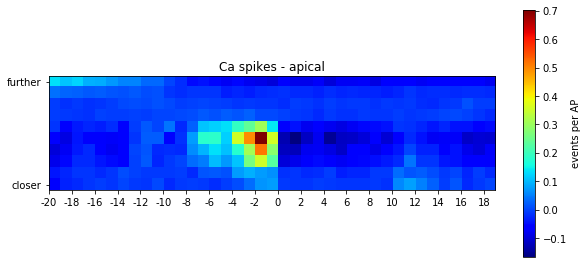

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Ca spikes - apical')
plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,40,2)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,2)])
plt.colorbar(label='events per AP')
plt.yticks(ticks=[0,9],labels=['further','closer'])

plt.show()

----------------------

In [28]:
apic_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='apic')].groupby('segmentID')['Conductance'].sum().reset_index()

basal_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='dend')].groupby('segmentID')['Conductance'].sum().reset_index()


In [10]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=260)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
    
    if (len(legit_uc_iso)!=0) & (np.min(nmda['report']['biophysical']['data'][:,p])!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=nmda['report']['biophysical']['data'])
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan}))
        

0


KeyboardInterrupt: 

In [29]:
#nmda_df.to_csv('64Hz_soma_inh_nmda_df.csv')
nmda_df = pd.read_csv('nmda_df.csv')

In [30]:
nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)

In [31]:
segs_nmda_df = segs.set_index('segmentID').join(nmda_df.set_index('segmentID')).reset_index()

In [32]:
def get_nmda_sta(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                   (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [33]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, spktimes)

In [34]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [35]:
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

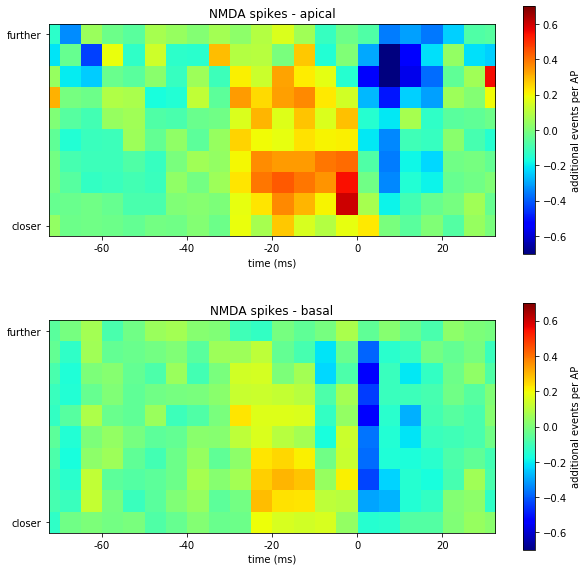

In [36]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.7,vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.7, vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

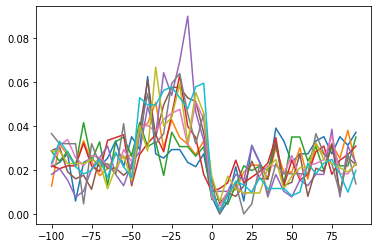

In [148]:
for i in np.arange(0,10):
    plt.plot(np.arange(-100,95,5),nmda_dend[i]/np.sum(nmda_dend[i]))


In [573]:
segs_conns[(segs_conns['Sec ID']==80) & (segs_conns.Type=='dend')]['Source Population'].value_counts()

dist_inh_stim    5
Name: Source Population, dtype: int64

(-150, 150)

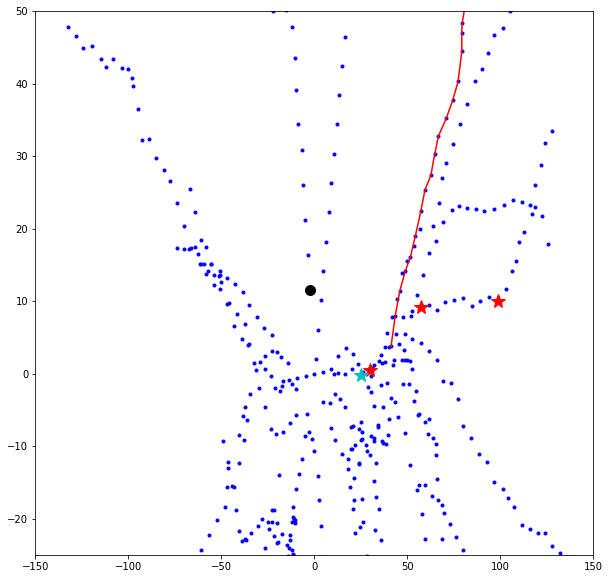

In [579]:
plt.figure(figsize=(10,10))
ind = 55
plt.plot(segs['Coord X'], segs['Coord Y'], 'b.')
plt.plot(segs.loc[0,'Coord X'], segs.loc[0,'Coord Y'], 'k.',markersize=20)

plt.plot(segs.loc[ind,'Coord X'], segs.loc[ind,'Coord Y'], 'r*',markersize=20)

for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==2)]['Sec ID'].unique():
    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='r')
    
#for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==7)]['Sec ID'].unique():
#    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='c')
    
#plt.plot(segs[segs.segmentID==119]['Coord X'], segs[segs.segmentID==119]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==110]['Coord X'], segs[segs.segmentID==110]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==103]['Coord X'], segs[segs.segmentID==103]['Coord Y'],'r*',markersize=14)

#plt.plot(segs[segs.segmentID==134]['Coord X'], segs[segs.segmentID==134]['Coord Y'],'c*',markersize=14)
plt.ylim(-25,50)
plt.xlim(-150,150)

(526419, 527519)

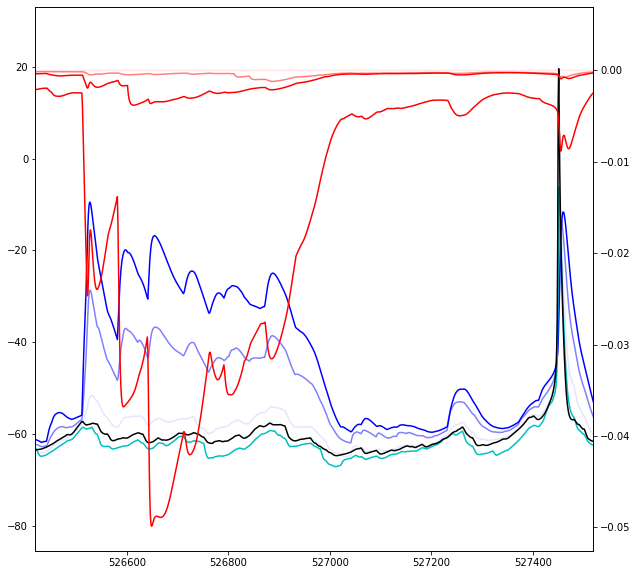

In [548]:
plt.figure(figsize=(10,10))
plt.plot(f['report']['biophysical']['data'][:,119],color='b')
plt.plot(f['report']['biophysical']['data'][:,110],color='b',alpha=0.5)
plt.plot(f['report']['biophysical']['data'][:,104],color='b',alpha=0.1)

plt.plot(f['report']['biophysical']['data'][:,134],color='c',alpha=1)
plt.plot(f['report']['biophysical']['data'][:,0],'k')
plt.twinx()
plt.plot(h['report']['biophysical']['data'][:,119],color='r')
plt.plot(h['report']['biophysical']['data'][:,110],color='r',alpha=0.5)
plt.plot(h['report']['biophysical']['data'][:,103],color='r',alpha=0.1)

plt.xlim(526519-100,526519+1000)

In [503]:
nmda2 = np.zeros((79,))

for i in spktimes:
    nmda_inds2 = np.sort(segs_nmda_df[(segs_nmda_df.Degrees<=3)&
             (~pd.isnull(segs_nmda_df.nmda_lower_bound))&
             (segs_nmda_df.mag<-0.1)&
                (segs_nmda_df.Type=='dend')]['nmda_lower_bound'].values.astype(int))

    x2, _ = np.histogram(nmda_inds2/10,bins=np.arange(i-40,i+40,1))
    nmda2 += x2
    
    #na_inds3 = segs_na_df[(segs_na_df.Degrees==3)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x3, _ = np.histogram(na_inds3/10,bins=np.arange(i-20,i+20,1))
    #na3 += x3
    
    #na_inds4 = segs_na_df[(segs_na_df.Degrees==4)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x4, _ = np.histogram(na_inds4/10,bins=np.arange(i-20,i+20,1))
    #na4 += x4
    
    #na_inds5 = segs_na_df[(segs_na_df.Degrees==5)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x5, _ = np.histogram(na_inds5/10,bins=np.arange(i-20,i+20,1))
    #na5 += x5
    

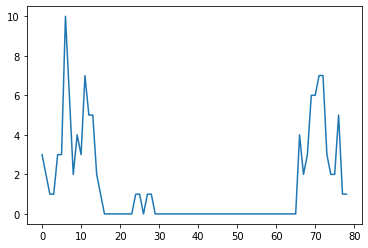

In [504]:
plt.plot(nmda2)

Text(0, 0.5, 'current (nA)')

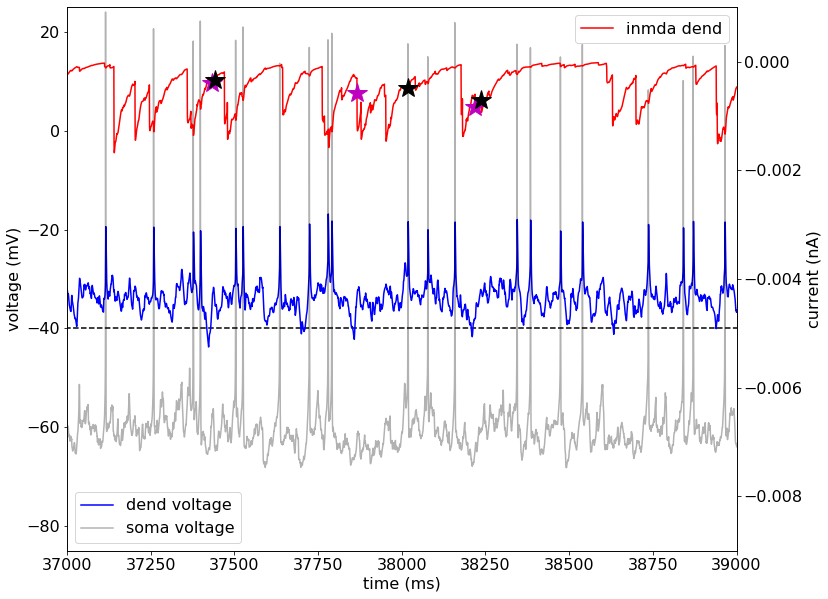

In [128]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

ind = 1139
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
plt.legend(loc='lower left')
plt.hlines(-40,0,60000,linestyle='dashed')
plt.ylabel('voltage (mV)')
plt.ylim(-85,25)
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
plt.legend(loc='upper right')
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
plt.ylim(-0.009,0.001)
plt.xlim(37000,39000)
plt.ylabel('current (nA)')


Text(0, 0.5, 'current (nA)')

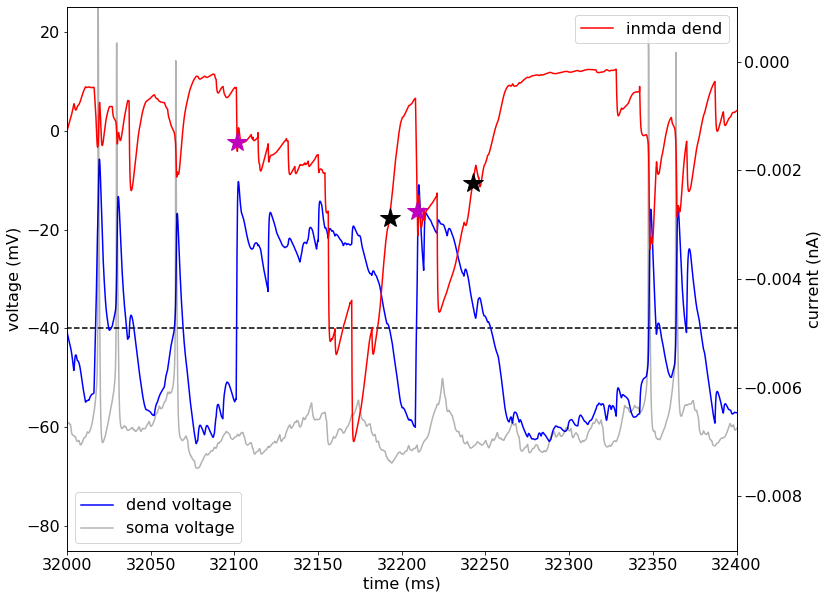

In [99]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
plt.legend(loc='lower left')
plt.hlines(-40,0,60000,linestyle='dashed')
plt.ylabel('voltage (mV)')
plt.ylim(-85,25)
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
plt.legend(loc='upper right')
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
plt.xlim(32000,32400)
plt.ylim(-0.009,0.001)
plt.ylabel('current (nA)')


In [46]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [44]:
np.arange(-30,31,5).shape

(13,)

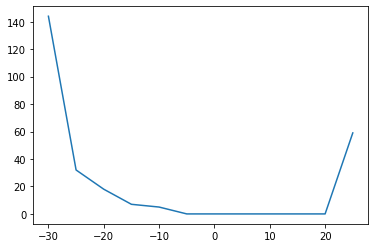

In [47]:
plt.plot(np.arange(-30,30,5),n)

In [26]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spktimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

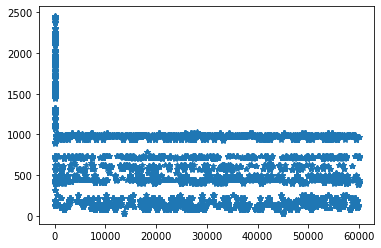

In [29]:
plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
         na_df[~pd.isnull(na_df.na_lower_bound)]['seg_id'],'*')

NameError: name 'nmda_df' is not defined

NameError: name 'n' is not defined

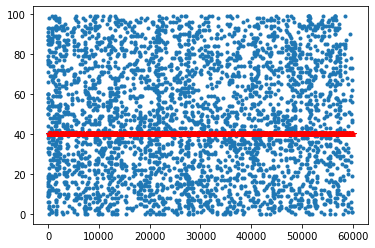

In [11]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spktimes,np.tile(40,len(spktimes)),'r*')

In [396]:
x1,_=np.histogram(spktimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

(6000, 7000)

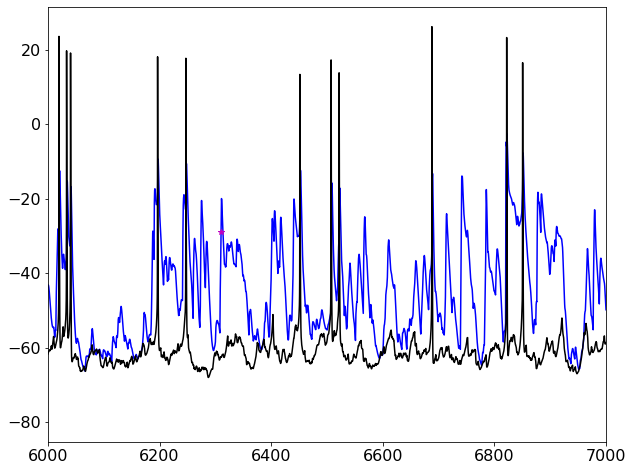

In [350]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
plt.xlim(6000,7000)

In [247]:
# ind1 = 3 sent to Drew
ind1 = 2
e1 = control_inmda[legit_uc_iso[ind1], p]
e2 = control_inmda[legit_dc_iso[ind1], p]
x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

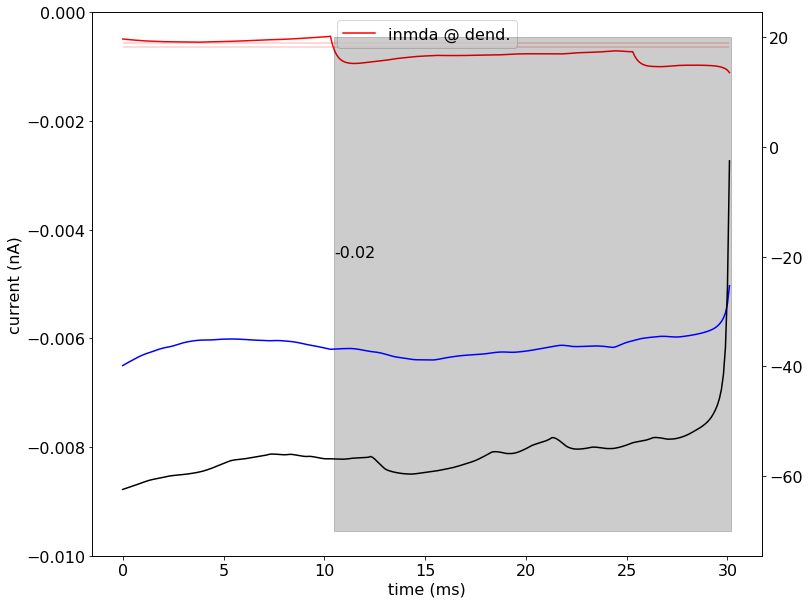

In [248]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
plt.ylabel('current (nA)')
plt.ylim(-0.010,0)
plt.legend(loc='upper center')
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


for i in np.arange(0,len(bounds)):
    plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
    plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
##plt.text(1.5,14,'NMDA\nspike')
#plt.ylabel('voltage (mV)')
#plt.legend()

Text(0.5, 1.0, '[  842  1647  2619  3554  4403  4838  5367  6259  6906  7343  9697 12390\n 12773 13771 14890 15884 17077 18595 19939 22066 23737 24284 25413 26597\n 27044 28429 30164 30801 31385 32087 32916 33723 35481 36024 37321 38402\n 39508 39990 41964 42943 43622 44147 45706 46043 46602 47522 48410 48800\n 49997 50965 51281 52498 53049 53683 54313 56634 57005 57875 59693 62229\n 63190 64370 64795 66494 68097 68880 69584 70642 71213 72545 73268 74657\n 75841 77213 79503 80633 81032 82026 82994 84010 85540 86223 87097 88434\n 91288 93667 94914 95493 96901 98894 99324]')

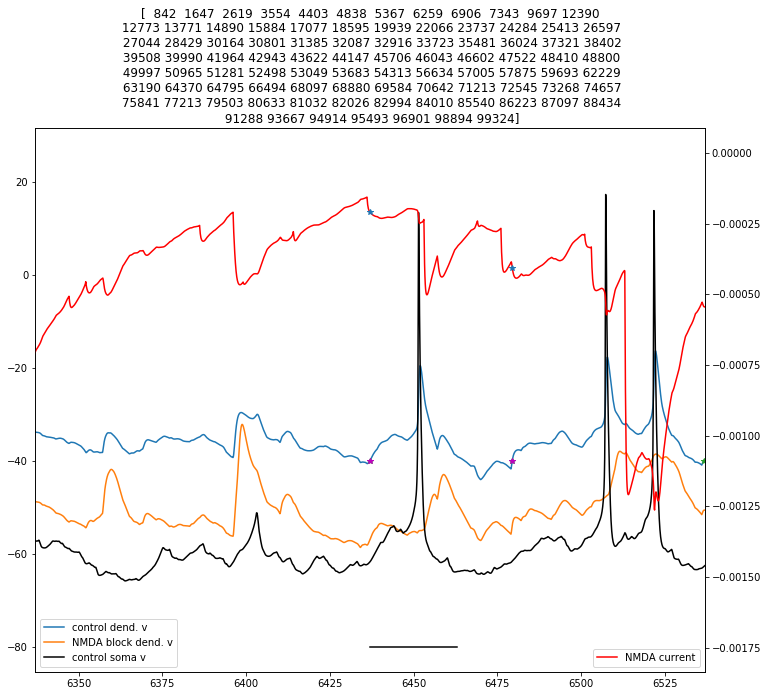

In [45]:
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

uc = voltage_criterion(control_v[:,p],-40)[0]


plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

plt.plot([center,center+26],[-80,-80],color='k')
plt.legend(loc='lower left')

plt.twinx()
plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
#plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
plt.xlim(center-100,center+100)

plt.legend(loc='lower right')
plt.title('{}'.format(legit_uc))

(-65, 0)

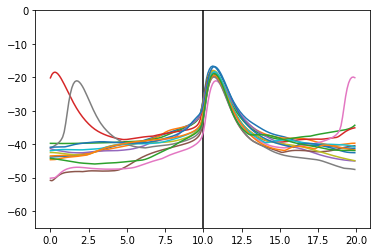

In [332]:
p = np.random.choice(segs[segs.Type=='apic'].index)
for i in spktimes:
    plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
plt.vlines(10,-65,0,color='k')
plt.ylim(-65,0)

No handles with labels found to put in legend.


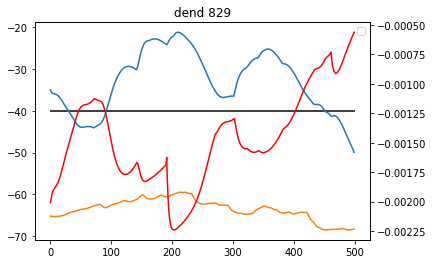

In [61]:
p = 829#np.random.choice(segs[segs.Type=='dend'].index)
plt.title('dend {}'.format(p))
plt.plot(control_v[7200:7700,p],label='dend')
plt.plot(control_v[7200:7700,0],label='soma')
plt.hlines(-40,0,500)
plt.twinx()
plt.plot(control_inmda[7200:7700,p],color='r')
plt.legend()

In [30]:
control_v[10000,0]

-64.93669985517535

(array([574., 247., 275., 347., 151., 246., 123., 100., 155., 308.]),
 array([-68.29374117, -61.6818314 , -55.06992164, -48.45801187,
        -41.8461021 , -35.23419233, -28.62228256, -22.01037279,
        -15.39846303,  -8.78655326,  -2.17464349]),
 <a list of 10 Patch objects>)

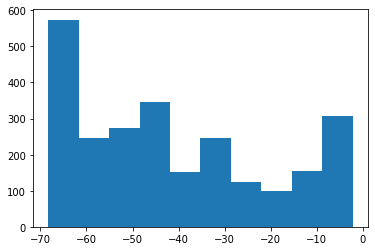

In [29]:
plt.hist(control_v[10000,:])

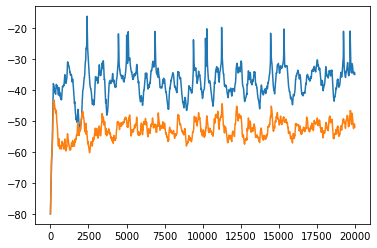

In [27]:
plt.plot(control_v[:,1200])
plt.plot(NMDAblock_v[:,1200])

In [16]:
df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [17]:
df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

(nan, -65.0773572393917)

In [18]:
df[(df.Distance>900) & (df.Distance<1000)]

,BMTK ID,X,Type,Sec ID,Distance,Coord X,Coord Y,Coord Z


(1740, 1760)

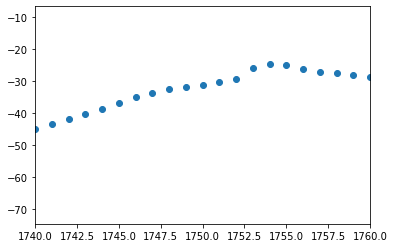

In [19]:
plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
plt.xlim(1740,1760)

Text(0, 0.5, 'mean potential of segment (mV)')

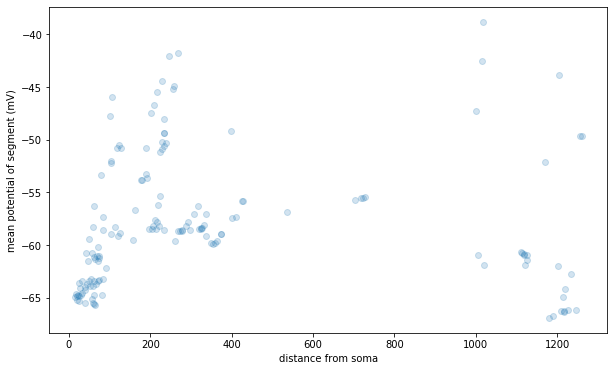

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(df['Distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
plt.xlabel('distance from soma')
plt.ylabel('mean potential of segment (mV)')

Text(0, 0.5, 'membrane potential (mV)')

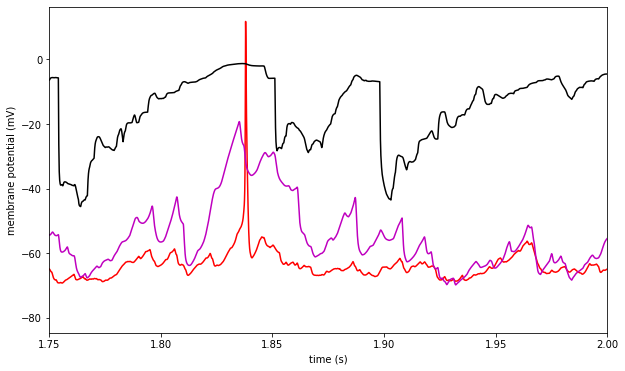

In [22]:
#plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

plt.figure(figsize=(10,6))

plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
plt.xlim(1.75,2)
plt.xlabel('time (s)')
plt.ylabel('membrane potential (mV)')